# Seattle Airbnb Data Analysis

This repository contains a comprehensive analysis of the [Seattle Airbnb
dataset](https://www.kaggle.com/datasets/airbnb/seattle/data), conducted using
the [CRoss Industry Standard Process for Data Mining -
CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)
methodology. 

The dataset includes detailed information about Airbnb listings, daily
availability, pricing, and user reviews in Seattle. The analysis aims to uncover
patterns and insights related to occupancy rates, pricing trends, and customer
satisfaction.

CRISP-DM methodology is consisted of the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation
6. Deployment

# 1. Business Understanding

*Objective: Understand the business objectives and requirements that motivate
data analysis.*

What is expected to be achieved with the analysis of the **Airbnb dataset in
Seattle**? Some possible objectives may be:

- **Q1. Identify temporal patterns in reserves and prices.**
- **Q2. Evaluate customer satisfaction based on reviews.**
- **Q3. Determine factors that influence property prices.**

# 2. Data Understanding

*Objective: Become familiar with the available data and evaluate its quality.*

## 2.1 Import libraries

In [85]:
import string
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/mafda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mafda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mafda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Some functions

In [86]:
def read_dataset(csv_file):
    # Read datasets
    df = pd.read_csv(csv_file)
    print("Number of rows and columns: ", df.shape)
    return df


def get_null_col(df):
    # Get null values and the porcentage
    pd.set_option("display.precision", 2)
    null_col = df.columns[df.isna().sum() > 0]
    col_null_val = df[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (df[null_col].isna().sum() / df.shape[0] * 100).sort_values(
        ascending=False
    )
    # Create a dataframe with results per column
    if len(col_null_val) > 0:
        nulls_df = pd.DataFrame(col_null_val, columns=["No. Nulls"])
        nulls_df["Nulls [%]"] = per_null_val
        print("Number of columns with missing data:", nulls_df.shape[0])
        return nulls_df
    else:
        print("No missing data")


def drop_cols(df):
    # Identify columns with more than 50% null values
    null_percentage = df.isnull().mean() * 100
    columns_to_drop = null_percentage[null_percentage > 50].index
    print("Columns with more than 50% null values:", len(columns_to_drop))

    if len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop, axis=1)
        print("Drop columns:", columns_to_drop)

    # Identify columns with a single value
    unique_value_columns = [
        col for col in df.columns if df[col].nunique() == 1
    ]
    print("Columns with a unique value:", len(unique_value_columns))

    if len(unique_value_columns) > 0:
        df = df.drop(columns=unique_value_columns, axis=1)
        print("Drop columns:", unique_value_columns)

    # Drop duplicate column
    duplicated_columns = set()
    for i in range(len(df.columns)):
        col1 = df.columns[i]
        for j in range(i + 1, len(df.columns)):
            col2 = df.columns[j]
            if df[col1].equals(df[col2]):
                duplicated_columns.add(col2)
    print("Duplicate column:", len(duplicated_columns))

    if len(duplicated_columns) > 0:
        df = df.drop(columns=duplicated_columns, axis=1)

    print("df cleaned:", df.shape)

    return df


def drop_rows(df, rows):
    # Show the number of null values ​​in each column
    null_counts = df.isnull().sum()
    drop_column = []

    # Check if any column has less than 10 rows with null values
    for column in df.columns:
        if null_counts[column] < rows and null_counts[column] > 0:
        # Delete rows with null values ​​in that column
            df.dropna(subset=column, axis=0, inplace=True)
            drop_column.append(column)

    print(f"Columns with less than {rows} null values:", len(drop_column))
    print(drop_column)
    print("df cleaned:", df.shape)

    return df


def remove_symbol(df, symbol, cols):
    # Remove symbol and format the columns as float
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(symbol, "")
            .str.replace(",", "")
            .astype("float32")
        )


def transform_datetime(df, columns):
    # Convert date column to datetime type
    for col in columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")


def transform_bool(df, columns):
    # Transform the bool features
    for col in columns:
        df[col] = df[col].map({'t':1,'f':0}).astype('bool')


def mean_missing_values(df, columns):
    # Dealing with numerical missing values columns 
    for col in columns:
        df[col].fillna(df[col].mean(), inplace=True)


def mode_missing_values(df, columns):
    # Dealing with categorical missing values columns 
    for col in columns:
        df[col].fillna(df[col].mode()[0],inplace=True)


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    text = " ".join([word for word in words if word not in stop_words])
    return text


def get_sentiment_vader(text):
    # Get the scores with Sentiment Analyzer Vader
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores["compound"]


def feeling_comments(df, feeling, samples):
    # Print random feeling comments
    print(f"Random comments with {feeling} sentiment:")
    sample_comments = (
        df.loc[df["sentiment_category_vader"] == feeling, ["comments"]]
        .sample(samples)
        .values
    )
    for comment in sample_comments:
        print("* " + comment[0])


## 2.2 Load datasets

### Calendar Dataset

In [87]:
df_calendar = read_dataset('../data/calendar.csv')
df_calendar.head()

Number of rows and columns:  (1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [88]:
get_null_col(df_calendar)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
price,459028,32.94


### Listings Dataset

In [89]:
df_listings = read_dataset('../data/listings.csv')
df_listings.head()

Number of rows and columns:  (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [90]:
get_null_col(df_listings)

Number of columns with missing data: 46


,No. Nulls,Nulls [%]
license,3818,100.00
square_feet,3721,97.46
monthly_price,2301,60.27
security_deposit,1952,51.13
weekly_price,1809,47.38
notes,1606,42.06
neighborhood_overview,1032,27.03
cleaning_fee,1030,26.98
transit,934,24.46
host_about,859,22.50


In [91]:
df_reviews = read_dataset('../data/reviews.csv')
df_reviews.head()

Number of rows and columns:  (84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [92]:
get_null_col(df_reviews)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
comments,18,0.02


- `df_calendar` has 1393570 lines and 4 columns. The number of columns with missing data is 1 with 32.94% missing values.
- `df_listings` has 3818 lines and 92 columns. The number of columns with missing data is 46 between 0.03% and 100% missing values.
- `df_reviews` has 84849 lines and 6 columns. The number of columns with missing data is 1 with 0.02% missing values.

## 3. Data Preparation

*Objective: Clean and transform data so that it is ready for analysis or modeling.*

### Calendar Dataset

In [93]:
# Clear and convert 'price' column
remove_symbol(df_calendar, "$", ["price"])

# Dealing with numerical missing values columns 
mean_missing_values(df_calendar, ["price"])

# Convert date column to datetime type
transform_datetime(df_calendar, ["date"])

# Create new columns for month and year
df_calendar["month"] = df_calendar["date"].dt.month
df_calendar["year"] = df_calendar["date"].dt.year

# Convert the available column to 1 or 0
transform_bool(df_calendar, ["available"])

In [94]:
# Treatment of null values
calendar_cleaned = drop_cols(df_calendar)

Columns with more than 50% null values: 0
Columns with a unique value: 0
Duplicate column: 0
df cleaned: (1393570, 6)


In [95]:
# Check for null values ​​after cleanup
get_null_col(calendar_cleaned)

No missing data


#### Exploratory analysis

- **Q1. Identify temporal patterns in reserves and prices**

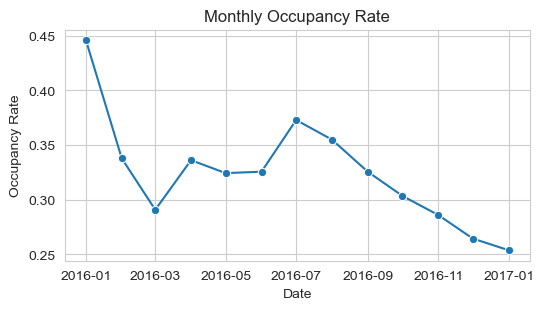

In [96]:
# Calculate monthly occupancy rate
occupancy_rate = (
    calendar_cleaned.groupby(["year", "month", "listing_id"])["available"]
    .mean()
    .reset_index()
)
occupancy_rate["occupancy_rate"] = 1 - occupancy_rate["available"]
occupancy_rate = occupancy_rate.drop("available", axis=1)
monthly_occupancy = (
    occupancy_rate.groupby(["year", "month"])["occupancy_rate"]
    .mean()
    .reset_index()
)

# Create a date column from the year and month
monthly_occupancy["date"] = pd.to_datetime(
    monthly_occupancy[["year", "month"]].assign(day=1)
)

# Graph monthly occupancy rate
plt.figure(figsize=(6, 3))
sns.lineplot(data=monthly_occupancy, x="date", y="occupancy_rate", marker='o')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.title("Monthly Occupancy Rate")
plt.grid(True)
plt.show()

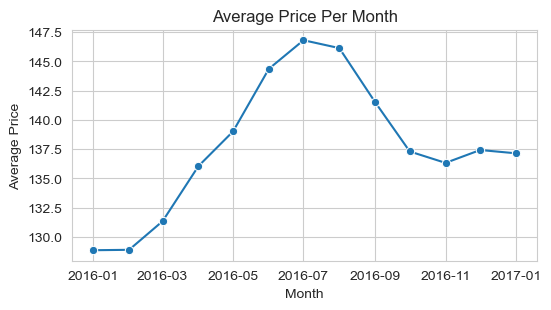

In [97]:
# Calculate monthly average price
avg_price_per_month = (
    calendar_cleaned.groupby(["year", "month"])["price"].mean().reset_index()
)

# Create a date column from the year and month
avg_price_per_month["date"] = pd.to_datetime(
    avg_price_per_month[["year", "month"]].assign(day=1)
)

# Graph price trend
plt.figure(figsize=(6, 3))
sns.lineplot(data=avg_price_per_month, x="date", y="price", marker='o')
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title("Average Price Per Month")
plt.grid(True)
plt.show()

#### Analysis of Results

- **Occupancy Rate**: The occupancy rate in Seattle shows distinct temporal
  patterns. The highest occupancy rate was observed in January 2016, which then
  decreased until March 2016. However, there was another increase in July 2016,
  starting from March 2016, which then began to decline until January 2017. This
  indicates a seasonal trend with peaks in winter (January) and summer (July),
  followed by gradual decreases.

- **Prices**: The average monthly prices also exhibit a temporal pattern.
  January 2016 had the lowest average price, which then increased steadily until
  July 2016. After July, prices slightly decreased until November 2016 and
  remained stable through January 2017. This suggests that prices tend to rise
  during periods of higher occupancy and demand, peaking in the summer.

The analysis reveals a relationship between occupancy rates and prices. Both
show seasonal trends with peaks in July and January, although prices lag
slightly behind occupancy rates. This correlation suggests that higher occupancy
rates, likely driven by seasonal demand, are associated with higher prices. This
pattern can be used to inform pricing and availability strategies for Airbnb
hosts in Seattle.

### Listings Dataset

In [98]:
# Treatment of null values
listings_cleaned = drop_cols(df_listings)

Columns with more than 50% null values: 4
Drop columns: Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')
Columns with a unique value: 10
Drop columns: ['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']
Duplicate column: 1
df cleaned: (3818, 77)


In [99]:
# Treatment of null values
listings_cleaned = drop_rows(listings_cleaned, 10)

Columns with less than 10 null values: 14
['host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'zipcode', 'property_type', 'bedrooms', 'beds']
df cleaned: (3795, 77)


In [100]:
# Identify columns that contain "url" in their name
url_columns = [col for col in listings_cleaned.columns if "url" in col.lower()]
print("Columns with 'url' in their name:")
print(url_columns)

# Remove columns that contain "url" in their name
listings_cleaned = listings_cleaned.drop(columns=url_columns, axis=1)
print(listings_cleaned.shape)

Columns with 'url' in their name:
['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
(3795, 69)


In [101]:
# Check remaining columns after removing null values
print(listings_cleaned.columns)

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review',

In [102]:
# Feature selection
host_features = ['host_since','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost', 'host_listings_count','host_verifications','host_has_profile_pic','host_identity_verified', 'calculated_host_listings_count']

review_features = ['instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','reviews_per_month','number_of_reviews','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']

property_features = ['neighbourhood','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','price','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']

features = host_features + review_features + property_features
listings_filtered = listings_cleaned.filter(features, axis=1)
listings_filtered.shape

(3795, 43)

In [103]:
# Remove symbols
remove_symbol(listings_filtered, "$", ["price", "cleaning_fee", "extra_people"])
remove_symbol(listings_filtered, "%", ["host_response_rate", "host_acceptance_rate"])

# Convert date column to datetime type
transform_datetime(listings_filtered, ["host_since", "first_review", "last_review"])

In [104]:
# Reformat other features
listings_filtered['host_response_time'] = listings_filtered.host_response_time.map(
    {"within an hour":1,"within a few hours":12, "within a day":24, "a few days or more":48}
    )
listings_filtered['cancellation_policy'] = listings_filtered['cancellation_policy'].map({'strict':0,'moderate':1,'flexible':2})

In [105]:
# Transform the bool features
bool_features =["host_is_superhost", 
"host_has_profile_pic", 
"host_identity_verified", 
"instant_bookable", 
"require_guest_profile_picture", 
"require_guest_phone_verification", 
"require_guest_profile_picture", 
"require_guest_phone_verification", 
"is_location_exact" ]

transform_bool(listings_filtered, bool_features)

In [106]:
# Check missing data
get_null_col(listings_filtered)

Number of columns with missing data: 16


,No. Nulls,Nulls [%]
cleaning_fee,1018,26.82
host_acceptance_rate,764,20.13
review_scores_accuracy,647,17.05
review_scores_checkin,647,17.05
review_scores_value,645,17.00
review_scores_location,644,16.97
review_scores_cleanliness,642,16.92
review_scores_communication,640,16.86
review_scores_rating,636,16.76
reviews_per_month,616,16.23


In [107]:
# Dealing with numerical missing values columns 
numerical_missing_values = ['beds', 'bedrooms', 'bathrooms', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'cleaning_fee', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_value', 'review_scores_location','review_scores_cleanliness','review_scores_communication', 'review_scores_rating', 'reviews_per_month']
mean_missing_values(listings_filtered, numerical_missing_values)

In [108]:
# Dealing with categorical missing values columns 
categorical_missing_values = ['property_type', 'neighbourhood', 'first_review', 'last_review', 'host_since']
mode_missing_values(listings_filtered, categorical_missing_values)

In [109]:
# Check missing data
get_null_col(listings_filtered)

No missing data


#### Exploratory analysis

In [115]:
# Price describe
listings_filtered['price'].describe()

count    3795.00
mean      127.92
std        90.27
min        20.00
25%        75.00
50%       100.00
75%       150.00
max      1000.00
Name: price, dtype: float64

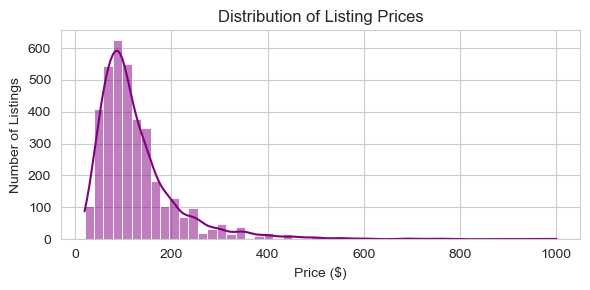

In [110]:
# Price Distribution
plt.figure(figsize=(6, 3))
sns.histplot(listings_filtered['price'], bins=50, kde=True, color="purple")
plt.title('Distribution of Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

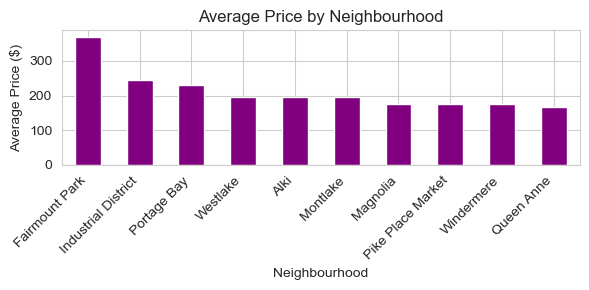

In [111]:
# Average Price by Neighbourhood
avg_price_by_neighbourhood = listings_filtered.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(6, 3))
avg_price_by_neighbourhood.plot(kind='bar', color='purple')
plt.title('Average Price by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



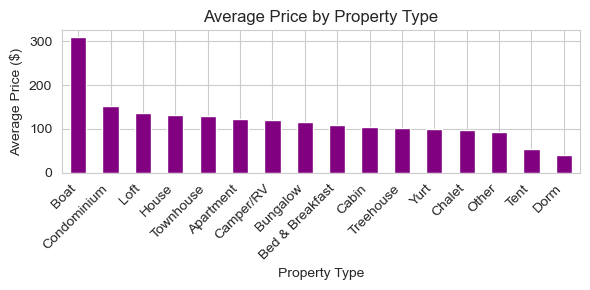

In [112]:
# Average Price by Property Type
avg_price_by_property = listings_filtered.groupby('property_type')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 3))
avg_price_by_property.plot(kind='bar', color='purple')
plt.title('Average Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

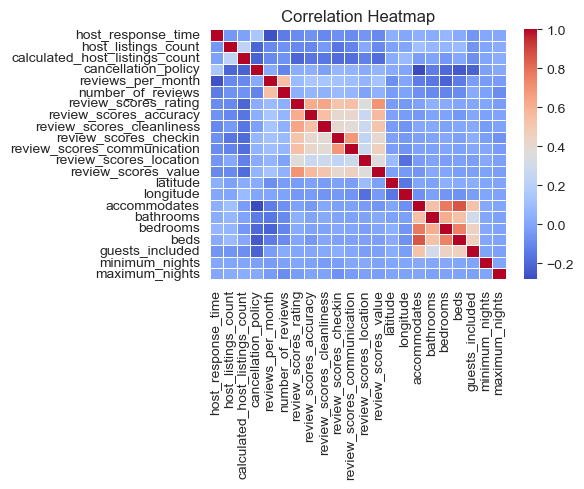

In [113]:
# Select relevant numeric columns
numeric_columns = listings_filtered.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


#### Analysis of Results

- **Price Distribution**: The histogram shows that most listings are priced
  around $100, with over 600 properties in this range. This suggests that $100
  is a common price for Airbnb listings in Seattle, possibly indicating a
  competitive and affordable market for most travelers.
- **Prices by Neighborhood**: The results of the bar plot indicate that the most
  expensive neighborhoods are Fairmount Park, standing out as one of the most
  expensive areas to stay. This analysis can be useful in identifying premium
  neighborhoods and helping homeowners adjust their prices based on location.
- **Correlations between Variables**: The correlation matrix shows that there is
  a high correlation between price and review-related variables (such as number
  of reviews and review score). Significant correlations are also observed with
  the number of bathrooms, beds, bedrooms, accommodation capacity and number of
  guests included. This suggests that these factors are key determinants of
  listing prices, with larger, better-reviewed properties tending to command
  higher prices.

The analyzes performed provide a clear view of the pricing dynamics in Airbnb
listings in Seattle. Understanding the distribution of prices, the factors that
affect them, and how they vary by property type and location can help homeowners
make informed decisions about pricing and marketing strategies.

### Reviews Dataset

In [ ]:
# Treatment of null values
reviews_cleaned = drop_rows(df_reviews, 20)

In [ ]:
# Treatment of null values
reviews_cleaned = drop_cols(reviews_cleaned)

In [ ]:
# Convert date column to datetime type
transform_datetime(reviews_cleaned, ["date"])

In [ ]:
# Clean text
reviews_cleaned['comments'] = reviews_cleaned['comments'].apply(clean_text)

#### Exploratory Analysis

- **Q2. Evaluate customer satisfaction based on reviews**

In [ ]:
# Date distribution of reviews
plt.figure(figsize=(6, 3))
reviews_cleaned['date'].hist(bins=50)
plt.title('Distribution of Review Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Analysis of the most frequent words in the reviews
# Join all comments
all_comments = ' '.join(reviews_cleaned['comments'].tolist())

# Count the most frequent words
word_counts = Counter(all_comments.split())
common_words = word_counts.most_common(10)

# Display the most frequent words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(6, 3))
sns.barplot(x='Word', y='Frequency', data=common_words_df, palette="viridis")
plt.title('Most Frequent Words in Reviews')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Apply sentiment analysis
reviews_cleaned["sentiment_vader"] = reviews_cleaned["comments"].apply(
    get_sentiment_vader
)

# Categorize feelings as positive, negative or neutral
reviews_cleaned["sentiment_category_vader"] = reviews_cleaned[
    "sentiment_vader"
].apply(
    lambda score: "positive"
    if score > 0
    else ("negative" if score < 0 else "neutral")
)

In [ ]:
# Count feelings using VADER
sentiment_counts_vader = reviews_cleaned[
    "sentiment_category_vader"
].value_counts()

# Calculate the proportion of each sentiment category
sentiment_proportions_vader = (
    sentiment_counts_vader / len(reviews_cleaned)
) * 100

reviews_cleaned.head(2)

In [ ]:
# Graph the distribution of feelings
plt.figure(figsize=(5, 5))
sns.barplot(
    x=sentiment_counts_vader.index,
    y=sentiment_counts_vader.values,
    palette="viridis",
)

# Add proportion labels to each bar
for i, proportion in enumerate(sentiment_proportions_vader):
    plt.text(
        i,
        sentiment_counts_vader.values[i],
        f"{proportion:.2f}%",
        ha="center",
        va="bottom",
    )

plt.title("Distribution of Feelings (VADER)")
plt.xlabel("Feeling")
plt.ylabel("Frequency")
plt.show()

In [ ]:
feeling_comments(reviews_cleaned, "positive", 2)

In [ ]:
feeling_comments(reviews_cleaned, "negative", 2)

In [ ]:
feeling_comments(reviews_cleaned, "neutral", 2)

#### Analysis of Results

- **Review Volume**: The year 2016 had the highest number of user reviews,
  indicating a significant level of engagement and feedback from customers
  during that period.
- **Commonly Used Words**: The most frequently used words in user reviews were
  "great," "clean," "location," and "comfortable." These keywords suggest that
  customers generally had positive experiences and appreciated the cleanliness,
  location, and comfort of the accommodations.

**Sentiment Analysis**:

- Positive Reviews: 97.42% of the comments were positive, reflecting a high
  level of customer satisfaction.
- Neutral Reviews: 1.85% of the comments were neutral.
- Negative Reviews: Only 0.73% of the comments were negative, indicating a very
  low level of dissatisfaction among users.
- *Language of Reviews: Some of the reviews classified as neutral or negative
  were written in languages other than English. This language variation could
  impact the accuracy of sentiment classification.*

**Suggestion**: It is recommended to clean the data to include only comments
written in English. This step would ensure more consistent and accurate
sentiment analysis, leading to better insights into customer satisfaction.

Overall, the analysis shows that customer satisfaction is overwhelmingly
positive, with a few areas for improvement in handling multilingual reviews.

# 4. Data Modeling

*Objective: Apply modeling techniques to identify patterns or predict values.*

In [173]:
# Define the characteristics (X) and the objective (y)
# X = numeric_columns
X = listings_filtered[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'reviews_per_month','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value', 'cleaning_fee', 'host_response_rate','host_acceptance_rate','host_is_superhost']]
y = listings_filtered['price']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [174]:
# We train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [175]:
# Predict on validation set
y_pred = model.predict(X_valid)

# 5. Evaluation

*Objective: Evaluate the results of the model in terms of accuracy and usefulness for the business.*

In [176]:
# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 3239.9372327865867
Mean Absolute Error (MAE): 38.09052779964685
R² Score: 0.5576846223142518


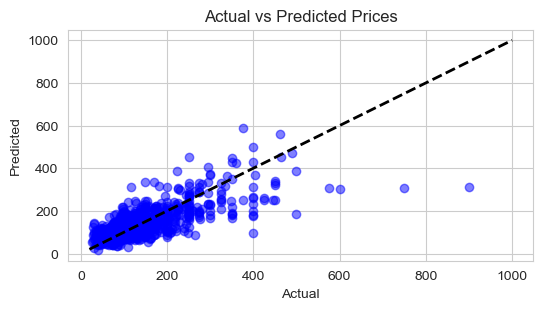

In [177]:
# View the results
plt.figure(figsize=(6,3))
plt.scatter(y_valid, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.show()

#### Analysis of Results

- An MAE of 38.09 means that, on average, the model predictions are off from the
  actual value by approximately $38.09. This is a more interpretable value and
  less sensitive to outliers compared to the MSE. A reduction in the MAE
  indicates that the model is improving in terms of absolute accuracy.
- An R² of 0.558 indicates that approximately 55.8% of the variability in
  property prices can be explained by the model. This suggests moderate to good
  predictive ability.
- Although the model has a reasonable level of predictive ability, an R² of
  0.558 also suggests that there is 44.2% of the variability that is not being
  captured by the model, indicating that some important features could be
  missing or that the model is not complex enough to Capture all relationships
  present in the data.

# 6. Deployment

*Objective: Implement the solution so that it can be used by the business.*

- Automate the data pipeline: 
  - Use scripts and tools to automate data collection, cleaning and analysis.
- Deploy the model to production: 
  - Use cloud services such as AWS, GCP or Azure to deploy the model.
  - Create an API so that other systems can access the model.

## Steps to Improve the Model

- Explore more price-relevant features.
- Test more complex models that can capture non-linear relationships.
- Apply regularization techniques to improve the robustness of the model.
- Perform an analysis and treatment of outliers.
- Use cross-validation for a more robust evaluation.